<h2>Thư viện và dữ liệu</h2>

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean as _mean, stddev as _stddev, when, lit
from math import sqrt
import matplotlib.pyplot as plt
import time

/home/hien/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Tạo hoặc lấy Spark session
spark = SparkSession.builder.master("spark://hien-VirtualBox:7077").appName("KMeansParallel").getOrCreate()

# Đọc dữ liệu
data = spark.read.format("csv")\
    .option("header", "true")\
    .option("inferSchema", "true")\
    .load("input/preprocessed.csv")

24/06/04 10:17:12 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
numerical_columns = ["Num_of_reviews", "General_rate", "Comfort", "Interior design", "Performance", "Value for the money", "Exterior styling", "Reliability"]
categorical_columns = ["Year", "Brand", "Model"]
feature_columns = numerical_columns + [col + "_encoded" for col in categorical_columns]

<h2>Giải thuật khai thác dữ liệu</h2>

In [4]:
# Chia dữ liệu thành training và test set
(train_data, test_data) = data.randomSplit([0.7, 0.3], seed=42)

# Chuyển đổi DataFrame thành RDD để sử dụng takeSample
train_rdd = train_data.select(feature_columns).rdd.map(lambda row: [row[col] for col in feature_columns])
test_rdd = test_data.select(feature_columns).rdd.map(lambda row: [row[col] for col in feature_columns])

In [5]:
# Các hàm hỗ trợ
def euclidean_distance(row, centroid):
    return sqrt(sum((row[i] - centroid[i]) ** 2 for i in range(len(row))))

def assign_cluster(row, centroids):
    distances = [euclidean_distance(row, centroid) for centroid in centroids]
    return distances.index(min(distances))

def compute_wss(data_rdd, centroids):
    return data_rdd.map(lambda row: min([euclidean_distance(row, centroid) ** 2 for centroid in centroids])).sum()

def kmeans(data_rdd, k, max_iterations=10):
    centroids = data_rdd.takeSample(False, k)
   
    for _ in range(max_iterations):
        clusters = data_rdd.map(lambda row: (assign_cluster(row, centroids), row)).groupByKey().mapValues(list)
        new_centroids = clusters.mapValues(lambda points: [sum([p[i] for p in points]) / len(points) for i in range(len(points[0]))])
        centroids = list(new_centroids.collectAsMap().values())
   
    wss = compute_wss(data_rdd, centroids)
    return centroids, wss

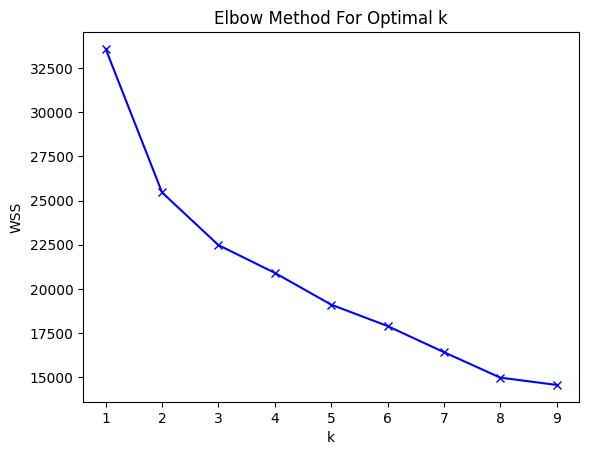

Optimal k value based on Elbow Method: 6


In [6]:
# Chạy K-means với các giá trị k khác nhau và tính WSS
k_values = range(1, 10)
wss_values = [kmeans(train_rdd, k)[1] for k in k_values]

# Vẽ biểu đồ Elbow
plt.plot(k_values, wss_values, 'bx-')
plt.xlabel('k')
plt.ylabel('WSS')
plt.title('Elbow Method For Optimal k')
plt.show()

# Tìm k tối ưu dựa trên phương pháp Elbow
optimal_k = None
min_diff = float('inf')

for i in range(1, len(wss_values) - 1):
    diff = wss_values[i - 1] - wss_values[i]
    if diff < min_diff:
        min_diff = diff
        optimal_k = k_values[i]

print("Optimal k value based on Elbow Method:", optimal_k)

In [7]:
# Chạy KMeans với k tối ưu từ phương pháp Elbow
k_optimal = optimal_k  # Thay thế giá trị này bằng giá trị từ phương pháp Elbow

# Chạy KMeans trên tập training
start_time = time.time()
centroids, _ = kmeans(train_rdd, k_optimal)
end_time = time.time()
print("Execution time: ", end_time - start_time)

# Gán cluster cho từng điểm dữ liệu
clustered_train_rdd = train_rdd.map(lambda row: (assign_cluster(row, centroids), row))
clustered_test_rdd = test_rdd.map(lambda row: (assign_cluster(row, centroids), row))

# Chuyển đổi RDD thành DataFrame để hiển thị kết quả
clustered_train_data = clustered_train_rdd.map(lambda x: (x[0],) + tuple(x[1])).toDF(["Cluster"] + feature_columns)
clustered_test_data = clustered_test_rdd.map(lambda x: (x[0],) + tuple(x[1])).toDF(["Cluster"] + feature_columns)

Execution time:  8.803509712219238


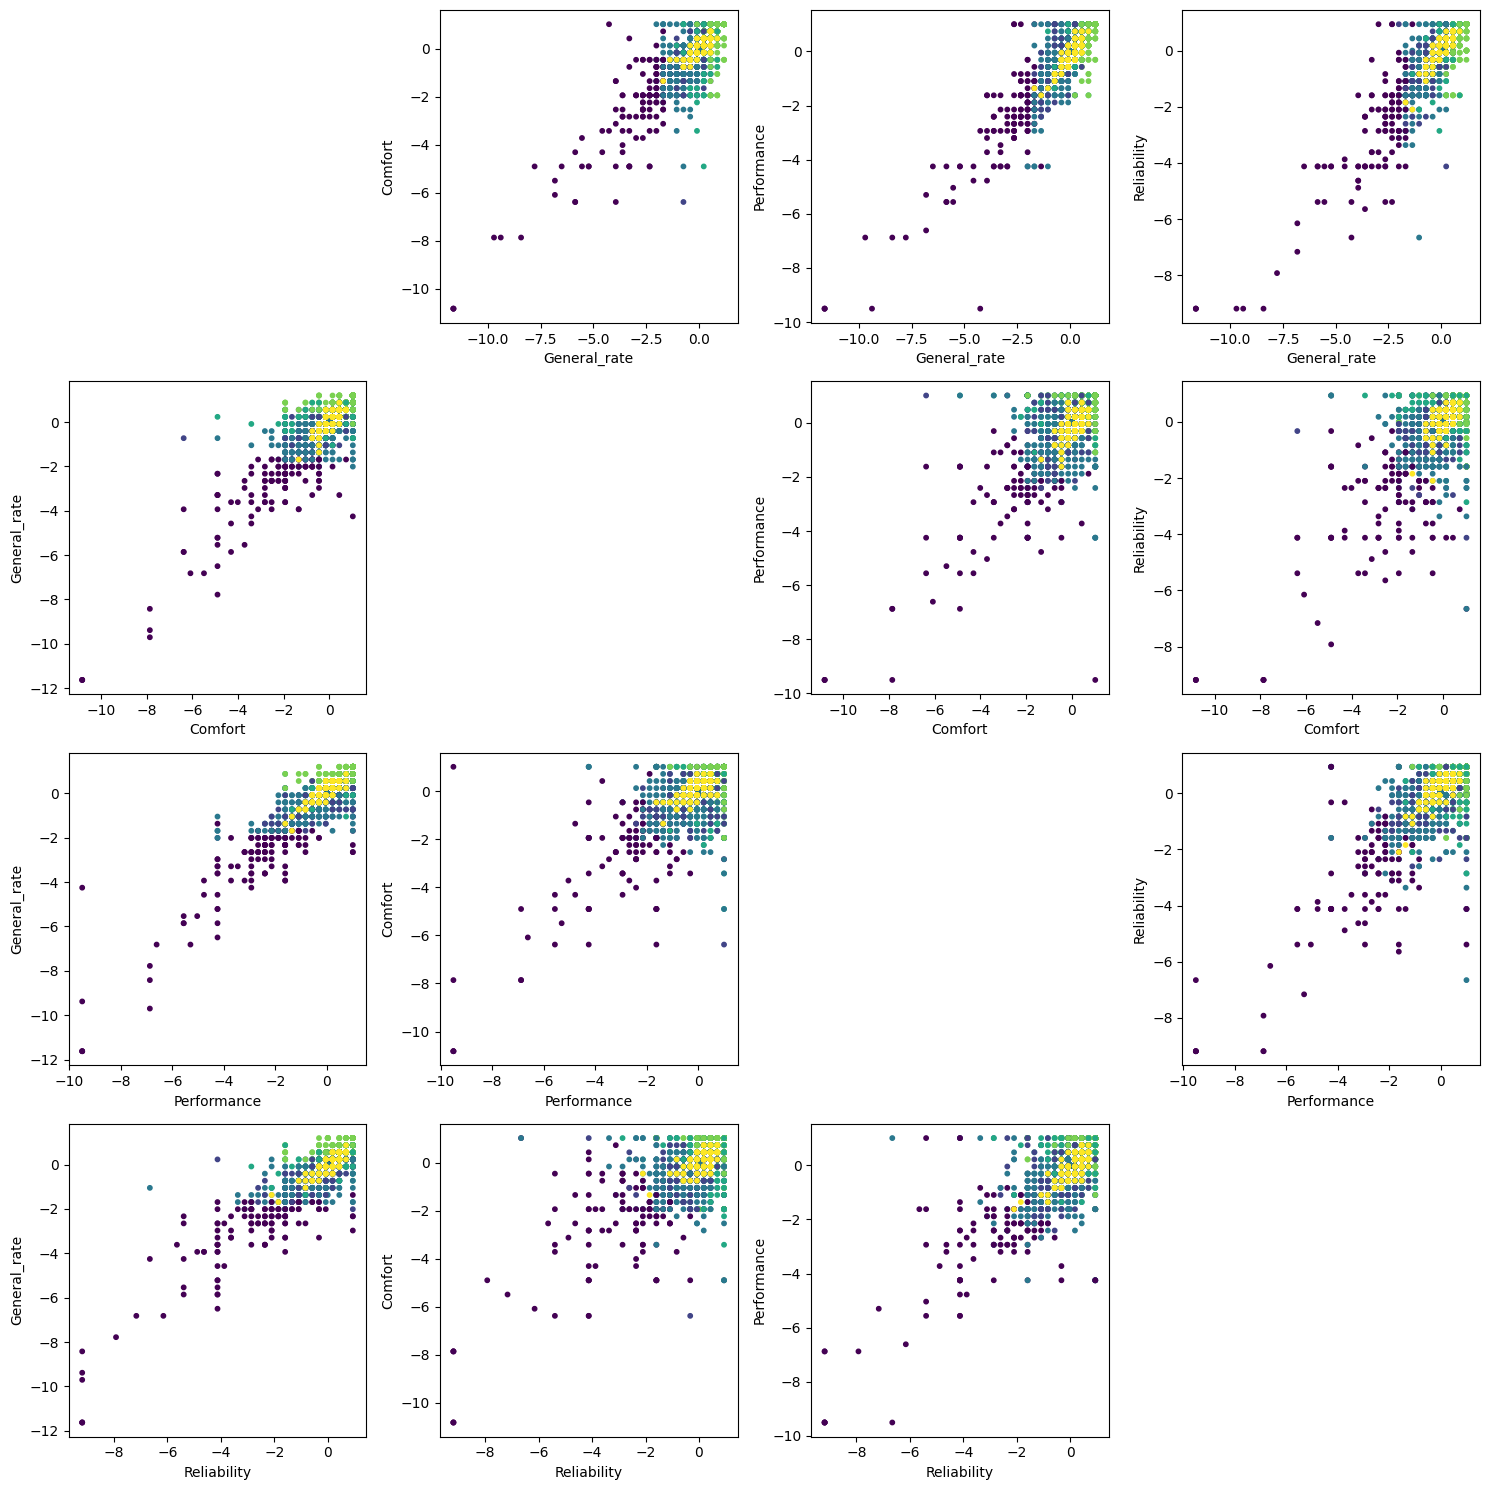

In [8]:
# Trực quan hóa dữ liệu: Tạo ma trận scatter plot
clustered_train_pd = clustered_train_data.toPandas()

# Tạo ma trận scatter plot cho các thuộc tính quan trọng
important_columns = ["General_rate", "Comfort", "Performance", "Reliability"]
num_attributes = len(important_columns)

fig, axes = plt.subplots(nrows=num_attributes, ncols=num_attributes, figsize=(15, 15))

for i in range(num_attributes):
    for j in range(num_attributes):
        if i != j:
            ax = axes[i, j]
            scatter = ax.scatter(clustered_train_pd[important_columns[i]], clustered_train_pd[important_columns[j]], c=clustered_train_pd['Cluster'], cmap='viridis', s=10)
            ax.set_xlabel(important_columns[i])
            ax.set_ylabel(important_columns[j])
        else:
            axes[i, j].set_visible(False)

plt.tight_layout()
plt.show()

In [9]:
# Dự đoán: Chọn một số dữ liệu ngẫu nhiên và gán cụm
random_data = test_rdd.takeSample(False, 5)
for row in random_data:
    predicted_cluster = assign_cluster(row, centroids)
    print(f"Predicted cluster for {row}: {predicted_cluster}")

Predicted cluster for [0.17457987915795176, -0.4069886696118216, 0.4296060494942297, 0.520380870177615, -0.569388397924097, -0.6851534523856326, 0.28000097400903196, -1.3398229461939466, 1.0065409473529756, -0.8174614866569524, 0.7745648654413795]: 2
Predicted cluster for [0.13826007733584822, 0.5546756306465788, 0.4296060494942297, -0.07696116457542704, 0.21881425451391234, 0.2965151490461411, 0.28000097400903196, 0.6849703203990164, 0.4339387834301124, 1.040885812883187, -1.6592170124473258]: 3
Predicted cluster for [6.9678282642143724e-15, 1.2527232351121155e-13, -1.8405114010865432e-14, -3.713824131131896e-14, -1.6334840345736235e-14, -3.487587468355624e-14, 7.601641212870375e-14, -4.945538630290474e-14, 1.5791431112758387, 0.46015228177689343, 1.0671760454165482]: 1
Predicted cluster for [-0.6365623615356939, 1.19578516415218, 1.0216722252159807, 1.1177229049306572, 1.0070169069519217, 1.278183750477917, 0.9646959446827771, 0.9380694787231356, -0.9975666263770457, 0.69244569421941

<h2>Đánh giá kết quả</h2>

In [10]:
# Hàm tính RMSE, MAE và R²
def calculate_rmse_mae_r2(data_rdd, centroids):
    n = data_rdd.count()
    sum_squared_errors = data_rdd.map(lambda row: euclidean_distance(row, centroids[assign_cluster(row, centroids)]) ** 2).sum()
    rmse = sqrt(sum_squared_errors / n)
    mae = data_rdd.map(lambda row: abs(euclidean_distance(row, centroids[assign_cluster(row, centroids)]))).mean()
    
    mean_actual = data_rdd.map(lambda row: row[2]).mean()
    total_sum_squares = data_rdd.map(lambda row: (row[2] - mean_actual) ** 2).sum()
    r2 = 1 - (sum_squared_errors / total_sum_squares)
    
    return rmse, mae, r2

# Tính toán cho tập train
rmse_train, mae_train, r2_train = calculate_rmse_mae_r2(train_rdd, centroids)
print(f"Train RMSE: {rmse_train}")
print(f"Train MAE: {mae_train}")
print(f"Train R²: {r2_train}")

# Tính toán cho tập test
rmse_test, mae_test, r2_test = calculate_rmse_mae_r2(test_rdd, centroids)
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test R²: {r2_test}")

Train RMSE: 2.46015613022893
Train MAE: 2.1587498878840443
Train R²: -4.993207527344938
Test RMSE: 2.437042935110904
Test MAE: 2.1427086393298445
Test R²: -5.101522261050462


<h2>Không song song</h2>

In [11]:
import random

# Hàm KMeans không song song
def kmeans_non_parallel(points, k, max_iterations):
    centers = random.sample(points, k)
    
    for _ in range(max_iterations):
        clusters = [[] for _ in range(k)]
        for point in points:
            center_idx = assign_cluster(point, centers)
            clusters[center_idx].append(point)
        
        new_centers = []
        for cluster in clusters:
            if cluster:
                new_center = [sum(dim) / len(cluster) for dim in zip(*cluster)]
                new_centers.append(new_center)
            else:
                new_centers.append(random.choice(points))
        
        centers = new_centers

    return centers, clusters

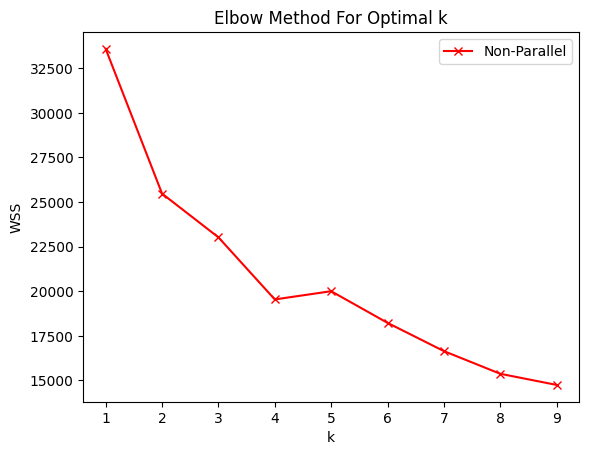

Optimal k value based on Elbow Method (Non-Parallel): 5


In [12]:
# Chạy KMeans không song song với các giá trị k khác nhau và tính WSS
train_list = train_rdd.collect()  # Chuyển đổi RDD thành list để dùng cho KMeans không song song
wss_values_non_parallel = []

for k in k_values:
    centers_non_parallel, clusters_non_parallel = kmeans_non_parallel(train_list, k, max_iterations=10)
    wss_non_parallel = sum(sum(euclidean_distance(point, centers_non_parallel[assign_cluster(point, centers_non_parallel)]) ** 2 for point in cluster) for cluster in clusters_non_parallel)
    wss_values_non_parallel.append(wss_non_parallel)

# Vẽ biểu đồ Elbow cho phiên bản không song song
plt.plot(k_values, wss_values_non_parallel, 'rx-', label='Non-Parallel')
plt.xlabel('k')
plt.ylabel('WSS')
plt.title('Elbow Method For Optimal k')
plt.legend()
plt.show()

# Tìm k tối ưu dựa trên phương pháp Elbow cho phiên bản không song song
optimal_k_non_parallel = None
min_diff_non_parallel = float('inf')

for i in range(1, len(wss_values_non_parallel) - 1):
    diff = wss_values_non_parallel[i - 1] - wss_values_non_parallel[i]
    if diff < min_diff_non_parallel:
        min_diff_non_parallel = diff
        optimal_k_non_parallel = k_values[i]

print("Optimal k value based on Elbow Method (Non-Parallel):", optimal_k_non_parallel)

In [13]:
# Chạy KMeans không song song với k tối ưu từ phương pháp Elbow
k_optimal_non_parallel = optimal_k_non_parallel  # Thay thế giá trị này bằng giá trị từ phương pháp Elbow

# Chạy KMeans không song song trên tập training
start_time_non_parallel = time.time()
centroids_non_parallel, _ = kmeans_non_parallel(train_list, k_optimal_non_parallel, max_iterations=10)
end_time_non_parallel = time.time()
print("Execution time (Non-Parallel): ", end_time_non_parallel - start_time_non_parallel)

Execution time (Non-Parallel):  0.6758911609649658


In [14]:
# Gán cluster cho từng điểm dữ liệu cho phiên bản không song song
clustered_train_rdd_non_parallel = train_rdd.map(lambda row: (assign_cluster(row, centroids_non_parallel), row))
clustered_test_rdd_non_parallel = test_rdd.map(lambda row: (assign_cluster(row, centroids_non_parallel), row))

clustered_train_data_non_parallel = clustered_train_rdd_non_parallel.map(lambda x: (x[0],) + tuple(x[1])).toDF(["Cluster"] + feature_columns)
clustered_test_data_non_parallel = clustered_test_rdd_non_parallel.map(lambda x: (x[0],) + tuple(x[1])).toDF(["Cluster"] + feature_columns)

In [15]:
# Dự đoán: Chọn một số dữ liệu ngẫu nhiên và gán cụm cho phiên bản không song song
random_data_non_parallel = test_rdd.takeSample(False, 5)
for row in random_data_non_parallel:
    predicted_cluster_non_parallel = assign_cluster(row, centroids_non_parallel)
    print(f"Predicted cluster for {row} (Non-Parallel): {predicted_cluster_non_parallel}")

Predicted cluster for [6.9678282642143724e-15, 1.2527232351121155e-13, -1.8405114010865432e-14, -3.713824131131896e-14, -1.6334840345736235e-14, -3.487587468355624e-14, 7.601641212870375e-14, -4.945538630290474e-14, -0.9975666263770457, -0.7013147804356936, -0.16364875924090766] (Non-Parallel): 1
Predicted cluster for [-0.5033897548546477, -2.6508720368814243, -0.1624601262275212, -1.2716452340815085, -2.6712621377587906, -3.630159256680958, -1.0893889673384551, -3.8708145294351466, 1.5791431112758387, -0.8174614866569524, 0.7931433530588505] (Non-Parallel): 2
Predicted cluster for [6.9678282642143724e-15, 1.2527232351121155e-13, -1.8405114010865432e-14, -3.713824131131896e-14, -1.6334840345736235e-14, -3.487587468355624e-14, 7.601641212870375e-14, -4.945538630290474e-14, -0.7112655444156141, -1.0497548990994698, -1.728886341012842] (Non-Parallel): 1
Predicted cluster for [6.9678282642143724e-15, 1.2527232351121155e-13, -1.8405114010865432e-14, -3.713824131131896e-14, -1.63348403457362

In [16]:
# Tính toán cho tập train cho phiên bản không song song
rmse_train_non_parallel, mae_train_non_parallel, r2_train_non_parallel = calculate_rmse_mae_r2(train_rdd, centroids_non_parallel)
print(f"Train RMSE (Non-Parallel): {rmse_train_non_parallel}")
print(f"Train MAE (Non-Parallel): {mae_train_non_parallel}")
print(f"Train R² (Non-Parallel): {r2_train_non_parallel}")

# Tính toán cho tập test cho phiên bản không song song
rmse_test_non_parallel, mae_test_non_parallel, r2_test_non_parallel = calculate_rmse_mae_r2(test_rdd, centroids_non_parallel)
print(f"Test RMSE (Non-Parallel): {rmse_test_non_parallel}")
print(f"Test MAE (Non-Parallel): {mae_test_non_parallel}")
print(f"Test R² (Non-Parallel): {r2_test_non_parallel}")

Train RMSE (Non-Parallel): 2.4366433401939713
Train MAE (Non-Parallel): 2.214636118298019
Train R² (Non-Parallel): -4.879195554199515
Test RMSE (Non-Parallel): 2.4930665504210126
Test MAE (Non-Parallel): 2.233922482504056
Test R² (Non-Parallel): -5.385274655021572


In [17]:
spark.stop()